## Lecture des données

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Les fichiers de données se présentent sous la forme de fichier .csv. Les trois premières lignes contiennent des informations relatives à la mesure, et sont donc ignorées.

In [232]:
df = pd.read_csv("data/0ppm-cal7-1.csv",
                sep=",",
                index_col=None,
                skiprows=3
                )
df.drop(index=[168,169,170], inplace=True)
df.head()

,Time [Sec],Cr53,Co59,Ni60,Cu63,Zn64,Ge72,As75,Se78,Mo98,Rh103,Cd111,Sb121,Te126,Gd157,Pt195,Hg202,Tl205,Pb208,U238
0,1.328,0.00,0.0,0.00,887.52,0.00,0.00,0.0,0.0,0.00,24785.34,10.0,6217.86,2283.49,550.01,83.33,66.67,0.00,866.69,1383.40
1,2.646,16.67,187.5,116.67,512.51,512.51,900.02,12.5,0.0,0.00,4283.89,0.0,3417.03,1150.04,683.35,100.00,250.00,33.33,1100.04,1483.41
2,3.964,0.00,200.0,83.33,287.50,362.50,700.01,12.5,0.0,0.00,2750.23,10.0,2866.92,1633.42,666.68,0.00,183.33,0.00,1466.74,1600.09
3,5.282,16.67,200.0,116.67,325.00,325.00,1100.04,25.0,0.0,16.67,3817.11,30.0,4017.16,1133.37,683.35,100.00,133.33,66.67,766.69,1450.07
4,6.6,83.33,162.5,150.00,500.01,212.50,616.68,0.0,0.0,0.00,3733.76,10.0,3033.62,1050.03,733.35,50.00,200.00,0.00,1000.03,1450.07


La première colonne est contient l'instant où la mesure d'intensité a été prise. Les autres colonnes contiennent les intensités pour chaque élément.
On peut remarquer que certaines valeurs des étalons sont nulles, ce qui les rend inutilisables pour le calcul d'intensité relative, puisqu'on ne peut pas diviser par 0. 

In [5]:
etalons = ["Ge72", "Rh103", "Te126"]
calibrants = ["Cu63", "Zn64", "Pt195", "Co59", "Ni60", "Se78", "Mo98", "Cd111"]
calibres = ["0", "2.5", "10", "50", "100", "300"]

Les noms des fichiers ont la même syntaxe, à savoir le calibre (la concentration d'étalon), suivit du numéro de la calibration (toujours 7 dans notre cas), puis du numéro de la mesure.
Cette syntaxe nous permet de créer une fonction qui ouvre et extrait les informations de plusieurs fichiers dans une boucle for, pour un calibre donné.

On peut alors créer une fonction qui calcule **l'intensité relative** par rapport à un étalon donné à la concentration voulue. Cette fonction réalise une moyenne sur les trois fichiers donnés par calibre et par étalon.

Cette fonction renvoie une dataframe contenant l'ensemble des intensités relatives de tous les éléments.

In [383]:
def get_relative_intensity_df(calibre, etalon):
    
    #Lecture des trois fichiers de données
    for no in ["1", "2", "3"]:
        df_temp = pd.read_csv("data/"+calibre+"ppm-cal7-"+no+".csv",
                sep=",",
                index_col=None,
                skiprows=3
                )
        # La dataframe est créée lors de la lecture du premier fichier
        if no == "1":
            df_rel = pd.DataFrame({"Time [Sec]": df_temp["Time [Sec]"]},
                         index=df.index
                         )
            df_rel[calibrants] = df_temp[calibrants].div(df_temp[etalon], axis=0)
        else:
            df_rel[calibrants] += df_temp[calibrants].div(df_temp[etalon], axis=0)
    
    #On divise par 3 pour obtenir la valeur moyenne
    df_rel[calibrants] *= 1/3
    return df_rel

In [384]:
get_relative_intensity_df("0", "Ge72")

,Time [Sec],Cu63,Zn64,Pt195,Co59,Ni60,Se78,Mo98,Cd111
0,1.328,inf,NaN,NaN,NaN,NaN,NaN,NaN,inf
1,2.646,0.355314,0.366465,0.069788,0.167037,0.080918,0.000000,0.012361,0.002410
2,3.964,0.377771,0.450428,0.047195,0.186050,0.105913,0.000000,0.004220,0.049565
3,5.282,0.260876,0.289149,0.058608,0.166156,0.072785,0.000000,0.009682,0.045518
4,6.6,0.426156,0.326857,0.054726,0.245363,0.124634,0.004237,0.000000,0.025088
...,...,...,...,...,...,...,...,...,...
163,216.172,0.411382,0.360777,0.015625,0.186219,0.094455,0.000000,0.018668,0.055620
164,217.49,0.312369,0.319522,0.020513,0.181065,0.045817,0.003378,0.000000,0.040492
165,218.808,0.388080,0.363388,0.025481,0.155935,0.100021,0.004237,0.034020,0.040248
166,220.126,0.283266,0.258327,0.034068,0.164026,0.106448,0.000000,0.000000,0.021274


On remarque la présence de "inf" et "NaN" sur la première ligne.<br> Cela est dû au fait que l'étalon a une valeur d'intensité nulle pour cet index. Python interprète une division par zéro comme un infini, sauf 0/0, qui est indéterminé (Not a Number).

Pour obtenir une estimation de l'erreur sur les intensités relatives, on utilise le RSD (Relative Standard Deviation), qui est le rapport entre l'écart-type et la moyenne de la série.

$$RSD=\frac{\sigma}{\overline{I}}$$

Cette fonction renvoie une dataframe semblable à la précédente, mais avec les RSD au lieu de la moyenne :

In [96]:
def get_RSD_df(calibre, etalon):
    for no in ["1", "2", "3"]:
        df_temp = pd.read_csv("data/"+calibre+"ppm-cal7-"+no+".csv",
                sep=",",
                index_col=None,
                skiprows=3
                )
        # La dataframe est créé lors de la lecture du premier fichier
        if no == "1":
            df_RSD = pd.DataFrame({"Time [Sec]": df_temp["Time [Sec]"]},
                         index=df.index
                         )
            df_RSD[calibrants] = (df_temp[calibrants].div(df_temp[etalon], axis=0) - get_relative_intensity_df(calibre, etalon)[calibrants]) ** 2
        else:
            df_RSD[calibrants] += (df_temp[calibrants].div(df_temp[etalon], axis=0) - get_relative_intensity_df(calibre, etalon)[calibrants]) ** 2
    #On divise par 3 et on prend la racine carrée pour obtenir l'écart-type
    df_RSD[calibrants] *= 1/2
    df_RSD[calibrants] **= 1/2
    #On divise par la moyenne pour obtenir le RSD
    df_RSD[calibrants] =  df_RSD[calibrants].div(get_relative_intensity_df(calibre, etalon)[calibrants], axis=0)
    return df_RSD

In [225]:
get_RSD_df("0", "Ge72").head()

,Time [Sec],Cu63,Zn64,Pt195,Co59,Ni60,Se78,Mo98,Cd111
0,1.328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.646,0.522079,0.512552,0.610760,0.275354,0.531505,NaN,0.975574,1.732051
2,3.964,0.435281,0.339659,1.295619,0.464243,0.825500,NaN,1.732051,1.087740
3,5.282,0.209362,0.197488,0.539029,0.095781,0.436006,NaN,0.868477,0.566145
4,6.6,0.798078,0.237411,0.450295,0.140386,0.861861,1.732051,NaN,0.477316


## Nettoyage des données

Les données que nous avons obtenues ne sont pas encore exploitables. En effet, si on tente de réaliser un graphique, on tombe sur cette représentation. 

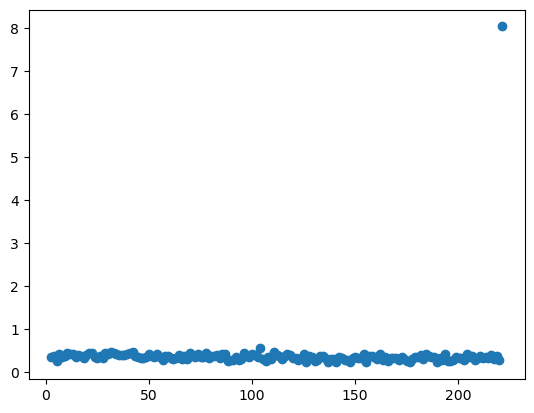

In [238]:
data=get_relative_intensity_df("0", "Ge72")
x = data["Time [Sec]"].astype(float)
y = data["Cu63"]
plt.scatter(x,y)

Le point très haut dans le graphique est un infini. Le programme le place ici à cause de la façon dont Python ajuste automatiquement les axes.<br> Pour obtenir des données exploitables, on enlève les "outliers", c'est à dire les valeurs suffisamment éloignées de la distribution des autres valeurs.

Ces outliers sont déterminés par rapport aux quartiles :<br>
$x$ est un outlier si $\begin{cases} x<Q_{1}-1,5(Q_{3}-Q_{1}) \\ x>Q_{3}+1,5(Q_{3}-Q_{1}) \end{cases}$.

La fonction suivante est très importante, puisque toute l'exploitation des données se fera à partir d'elle.<br>
C'est pour cette raison que l'on calcule également l'erreur standard sur la valeur :
$$ ES=\frac{\sigma}{\sqrt{n-1}} $$

In [379]:
def get_clean_intensity_df(calibrant, calibre, etalon):
    data = get_relative_intensity_df(calibre, etalon)[["Time [Sec]", calibrant]]
    data["RSD"] = get_RSD_df(calibre, etalon)[calibrant]
    data["Erreur"] = data.RSD * data[calibrant] / np.sqrt(2)
    
    #Calcul des quartiles
    Q1 = data[calibrant].quantile(0.25)
    Q3 = data[calibrant].quantile(0.75)
    
    #Outliers
    quartile_gap = Q3 - Q1
    outlier_max = Q3 + 1.5 * quartile_gap
    outlier_min = Q1 - 1.5 * quartile_gap
    
    #Suppression des outliers
    data.drop(index=[0, 167], inplace=True)
    data_clean = data[(data[calibrant] < outlier_max) & (data[calibrant] > outlier_min)]
    
    return data_clean

In [380]:
get_clean_intensity_df("Cu63", "0", "Ge72").head()

,Time [Sec],Cu63,RSD,Erreur
1,2.646,0.355314,0.522079,0.131170
2,3.964,0.377771,0.435281,0.116274
3,5.282,0.260876,0.209362,0.038620
4,6.6,0.426156,0.798078,0.240491
5,7.918,0.359187,0.100708,0.025578


In [381]:
def get_intensity_plot(calibrant, calibre, etalon):
    data = get_clean_intensity_df(calibrant, calibre, etalon)
    
    x = data["Time [Sec]"].astype(float)
    y = data[calibrant]
    error = data["Erreur"]
    plt.errorbar(x, y, yerr=error, fmt="bo")
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity")
    plt.title("Calibrant: "+calibrant+", Etalon: "+etalon+" at "+calibre+" ppm")
    return

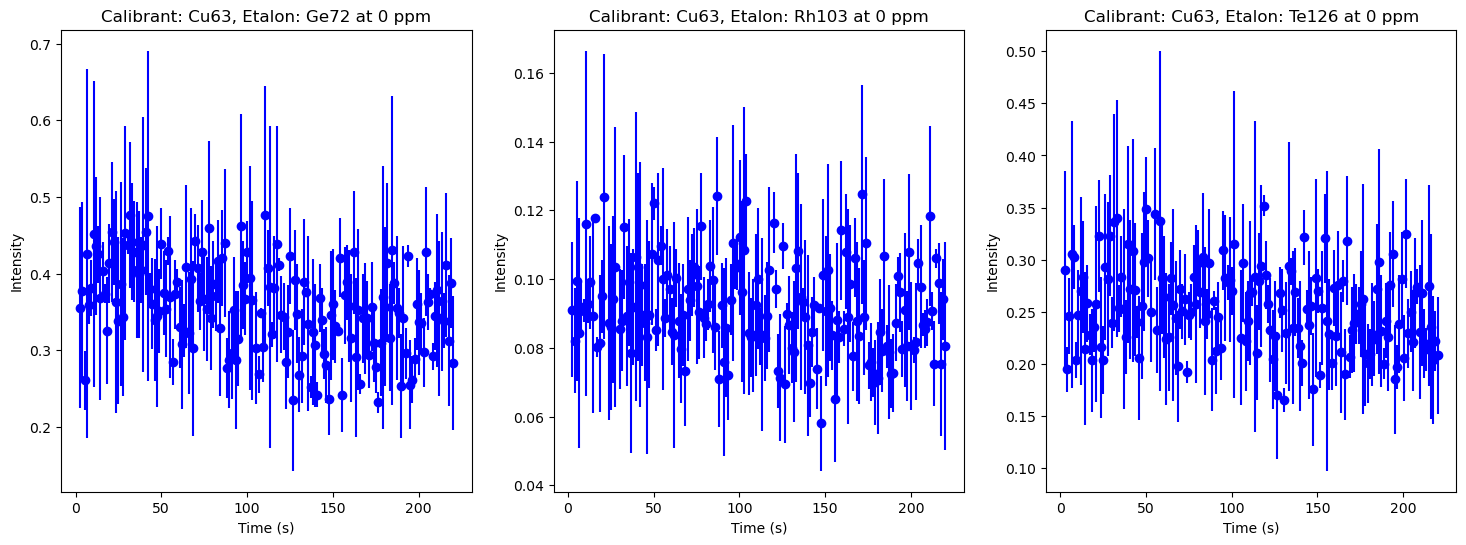

In [409]:
calibre = calibres[0]
calibrant = calibrants[0]
plt.figure(figsize=(18, 6))
i = 1
for etalon in etalons:
    plt.subplot(1,3,i)
    get_intensity_plot(calibrant, calibre, etalon)
    i += 1

## Étalonnage

Le but étant de réaliser une régression linéaire, on crée pour cela une dataframe contenant l'intensité relative pour chaque concentration pour un calibrant et un étalon donnés.<br>
La fonction suivante calcule l'intensité relative moyenne pour le calibrant et l'étalon indiqués à partir de la dataframe créée à la fin de la partie précédente.

In [257]:
def get_average_intensity_calibrant_df(calibrant, etalon):
    for calibre in calibres:
        data = get_clean_intensity_df(calibrant, calibre, etalon)
        if calibre == calibres[0]:
            average = [data[calibrant].mean(axis=0)]
            std_dev = [data[calibrant].std(axis=0)] 
            error = [data["Erreur"].mean(axis=0)]
        else:
            average.append(data[calibrant].mean(axis=0))
            std_dev.append(data[calibrant].std(axis=0))
            error.append(data["Erreur"].mean(axis=0))
    average_df = pd.DataFrame({"Concentration": calibres, 
                               "Intensité": average, 
                               "Écart-type": std_dev,
                               "Erreur": error}
                         )
    #Les concentrations sont des chaînes de caractère : il faut les transformer en réels 
    average_df.Concentration = average_df.Concentration.astype(float)
    return average_df

In [258]:
get_average_intensity_calibrant_df("Cu63", "Ge72")

,Concentration,Intensité,Écart-type,Erreur
0,0.0,0.358186,0.057551,0.057583
1,2.5,0.629084,0.098979,0.100738
2,10.0,1.133691,0.153784,0.158943
3,50.0,3.778718,0.434114,0.427012
4,100.0,6.182924,0.781663,0.679375
5,300.0,15.886802,2.025653,1.796409


Maintenant que nous avons une dataframe avec la concentration et l'intensité, nous pouvons effectuer la régression linéaire.<br>
Le modèle que l'on cherche a la forme $ \hat{C}=\hat{\beta_{0}}+\hat{\beta_{1}}I $.<br>
La pente $\hat{\beta_{1}}$ s'obtient à partir de la formule : $$ \hat{\beta_{1}} = \frac{Cov(I, C)}{Var(I)} $$ 
où $Cov(I, C)$ est la covariance de $I$ et $C$ : $$Cov(I, C)= \frac{1}{n-1}\sum (I-\bar{I})(C-\bar{C})$$
et $Var(I)$ est la variance de $I$ : $$Var(I)= \frac{1}{n-1}\sum (I-\bar{I})^{2}$$
L'ordonnée à l'origine s'obtient ensuite facilement par 
$$ \hat{\beta_{0}} = \bar{C}-\hat{\beta_{1}}\bar{I} $$

Pour évaluer la précision du modèle, on calcule également le $R^{2}$ :
$$R^{2} = 1 - \frac{\sum (C-\hat{C})^{2}}{\sum (C-\bar{C})^{2}}$$

Pour évaluer l'erreur, on utilise les formules permettant de calculer la variance des coefficients de régression :
$$ Var(\hat{\beta_{1}}) = \frac{\hat{\sigma}^{2}}{\sum (I-\bar{I})^{2}} $$
$\hat{\sigma}^{2}$ est la variance des valeurs estimées : $\hat{\sigma}^{2} = \frac{1}{n-2} \sum (C-\hat{C})^{2} $
$$ Var(\hat{\beta_{0}}) = \frac{1}{n} \frac{\hat{\sigma}^{2} \sum I^{2}}{\sum (I-\bar{I})^{2}} $$

In [378]:
def linear_reg(calibrant, etalon):
    data = get_average_intensity_calibrant_df(calibrant, etalon)
    
    #Calcul de la pente
    covariance = np.cov(data["Intensité"], data["Concentration"])[0][1]
    variance = data["Intensité"].var()
    pente = covariance / variance
    
    #Calcul de l'origine
    origine = data["Concentration"].mean() - pente * data["Intensité"].mean()
    
    #Calcul du R²
    residual_sum_squares_y = ((data["Concentration"] - (data["Intensité"] * pente + origine))**2).sum()
    total_sum_squares_y = ((data["Concentration"] - data["Concentration"].mean(axis = 0))**2).sum()
    R2 = 1-residual_sum_squares_y/total_sum_squares_y
    
    #Calcul des erreurs standards
    var_y = residual_sum_squares_y * 1/4
    total_sum_squares_x = ((data["Intensité"] - data["Intensité"].mean(axis = 0))**2).sum()
    error_pente = np.sqrt(var_y/total_sum_squares_x)
    error_origine = np.sqrt((data["Intensité"] ** 2).sum() * (var_y/total_sum_squares_x) * 1/6)
    
    return [pente, origine, R2, error_pente, error_origine]

In [385]:
def draw_calibration_graph(calibrant, etalon):
    
    #Obtention des données
    data = get_average_intensity_calibrant_df(calibrant, etalon)
    x = data["Intensité"]
    y = data["Concentration"]
    n = get_clean_intensity_df(calibrant, "0", etalon)[calibrant].size
    
    #Obtention du modèle
    regression = linear_reg(calibrant, etalon)
    origine = np.round(regression[1], 1)
    pente = np.round(regression[0], 1)
    R2 = np.round(regression[2], 3).astype(str)
    
    #Calcul de l'erreur standard
    error_pente = np.round(regression[3], 1).astype(str)
    error_origine = np.round(regression[4], 1).astype(str)
    error = data["Écart-type"] / np.sqrt(n-1) + data["Erreur"]
    
    plt.errorbar(x, y, xerr=error, fmt="ro")
    plt.plot(x, x * pente + origine, 
             label=etalon+": ("+origine.astype(str)+"±"+error_origine+") + ("+pente.astype(str)+"±"+error_pente+")C, R²="+R2)
    plt.xlabel("Intensité")
    plt.ylabel("Concentration (ppm)")
    plt.title(calibrant)
    plt.legend()

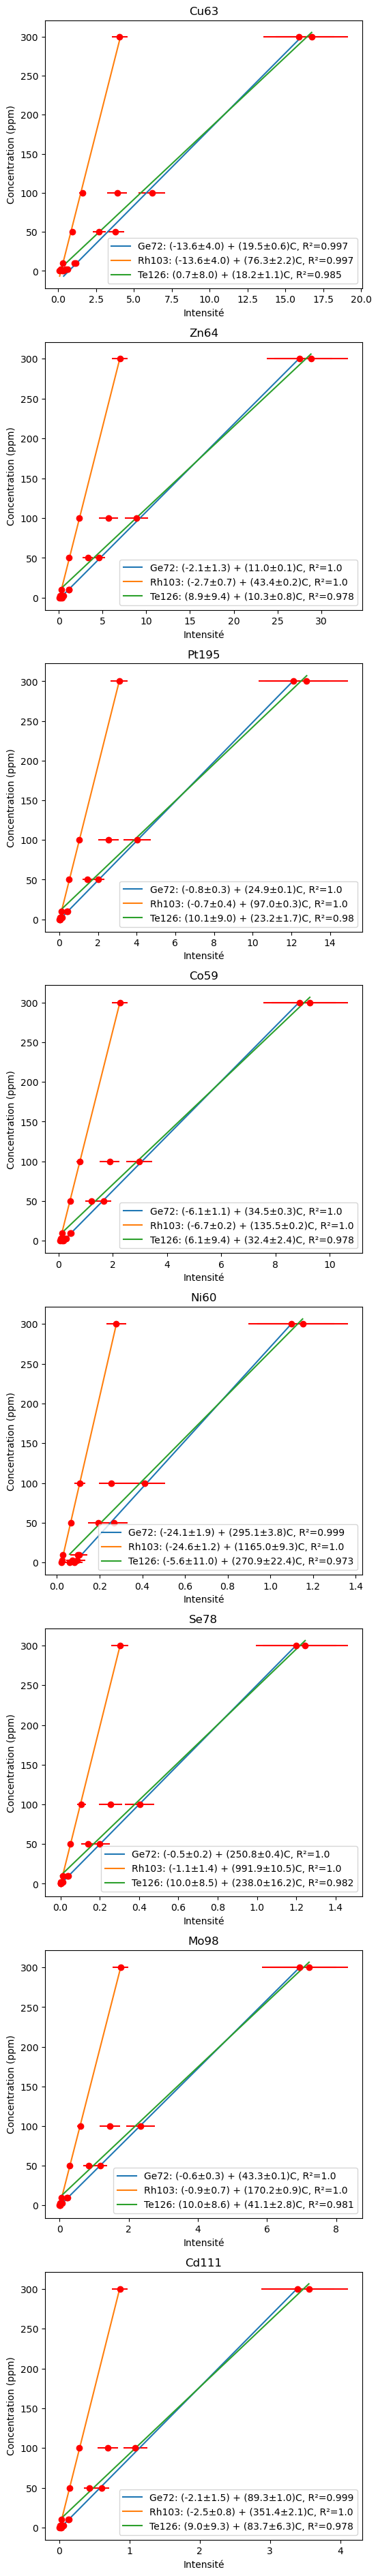

In [414]:
plt.figure(figsize=(6, 6*8))
i = 1
for calibrant in calibrants:
    plt.subplot(8,1,i)
    for etalon in etalons:
        draw_calibration_graph(calibrant, etalon)
    i += 1

In [122]:
def get_concentration(intensity, calibrant, etalon):
    regression = linear_reg(calibrant, etalon)
    concentration = (regression[1]+regression[0]*intensity)
    erreur = (regression[4]+regression[3]*intensity)
    return [concentration, erreur]

In [123]:
get_concentration(2,"Cd111", "Te126")

[176.39017095462916, 4.724459590885532]

In [427]:
def draw_image_intensity(nbr_lines, calibrant, etalon):
    for line in range(1,nbr_lines+1):
        df_temp = pd.read_csv("data/image/01-51T-OC-"+str(line)+".csv",
                    sep=",",
                    index_col=None,
                    skiprows=3
                    )
        new_column = pd.DataFrame({line: df_temp[calibrant].div(df_temp[etalon], axis=0)},
                                 index=df_temp.index
                                 )
        if line == 1:
            df = new_column.copy()
        else:
            df = pd.concat([df,new_column[line]], axis=1)
    
    df.drop(index=[173,174,175], inplace=True)
    Q1 = df.quantile(0.25).mean()
    Q3 = df.quantile(0.75).mean()
    outlier_max = Q3 + 1.5 * (Q3-Q1)
    outlier_min = Q1 - 1.5 * (Q3-Q1)
    
    x = [*range(0,173)]
    y = [*range(1,nbr_lines+1)]
    z = df.loc[x, y]
    
    plt.imshow(z, vmin=outlier_min, vmax=outlier_max, aspect="auto")
    plt.colorbar()
    plt.title(calibrant+"étalonné par rapport à "+etalon)

In [422]:
def draw_image_concentration(nbr_lines, calibrant, etalon):
    regression = linear_reg(calibrant, etalon)
    for line in range(1,nbr_lines+1):
        df_temp = pd.read_csv("data/image/01-51T-OC-"+str(line)+".csv",
                    sep=",",
                    index_col=None,
                    skiprows=3
                    )
        new_column = pd.DataFrame({line: df_temp[calibrant]*regression[0]+regression[1]},
                                 index=df_temp.index
                                 )
        if line == 1:
            df = new_column.copy()
        else:
            df = pd.concat([df,new_column[line]], axis=1)
            
    df.drop(index=[173,174,175], inplace=True)
    Q1 = df.quantile(0.25).mean()
    Q3 = df.quantile(0.75).mean()
    outlier_max = Q3 + 1.5 * (Q3-Q1)
    outlier_min = Q1 - 1.5 * (Q3-Q1)
    
    x = [*range(0,173)]
    y = [*range(1,nbr_lines+1)]
    z = df.loc[x, y]
    
    plt.imshow(z, vmin=outlier_min, vmax=outlier_max, aspect="auto")
    plt.colorbar()
    plt.title(calibrant+"étalonné par rapport à "+etalon)

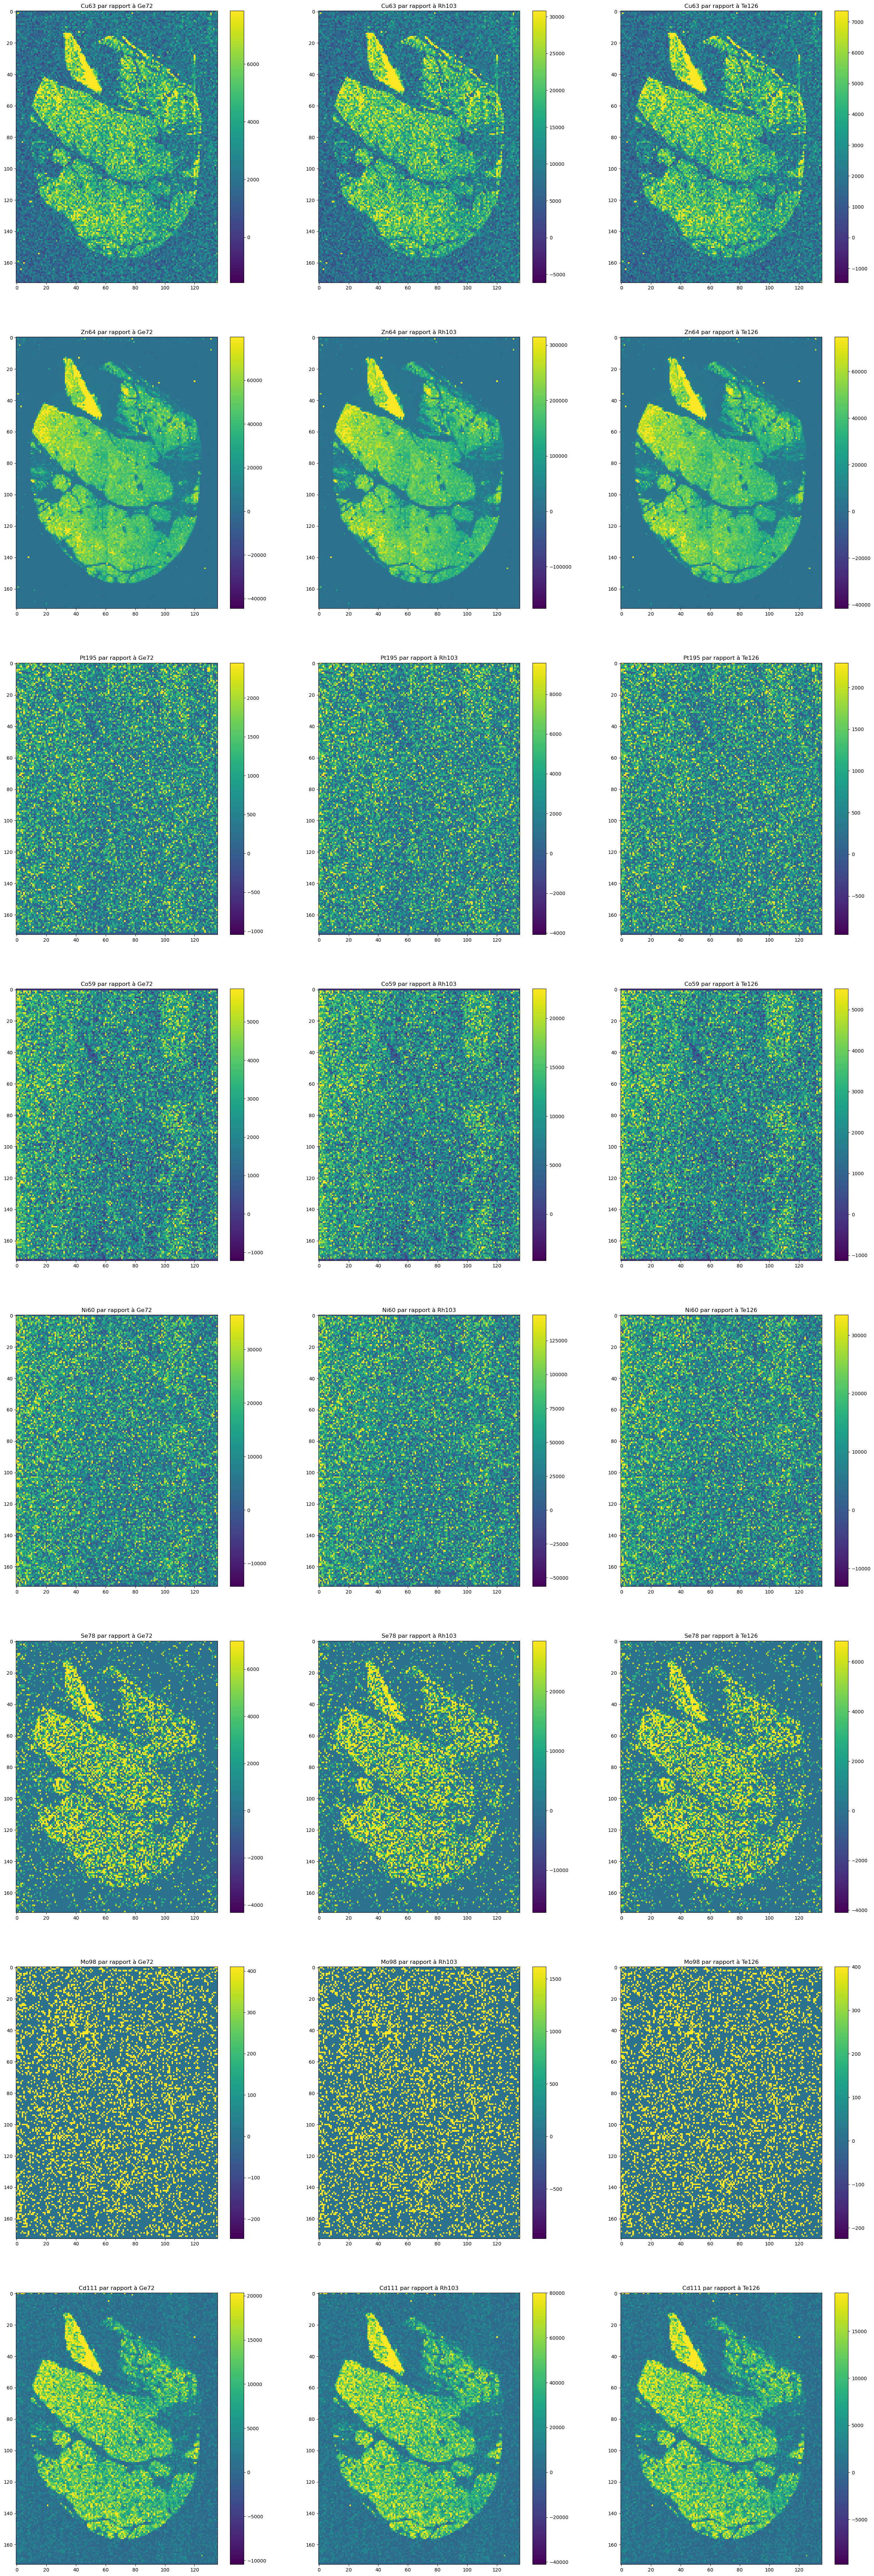

In [421]:
plt.figure(figsize=(8*4, 8*4*3))
j = 1
for calibrant in calibrants:
    i=1
    for etalon in etalons:
        plt.subplot(8,3,i+(j-1)*3)
        draw_image_concentration(136, calibrant, etalon)
        i += 1
    j += 1

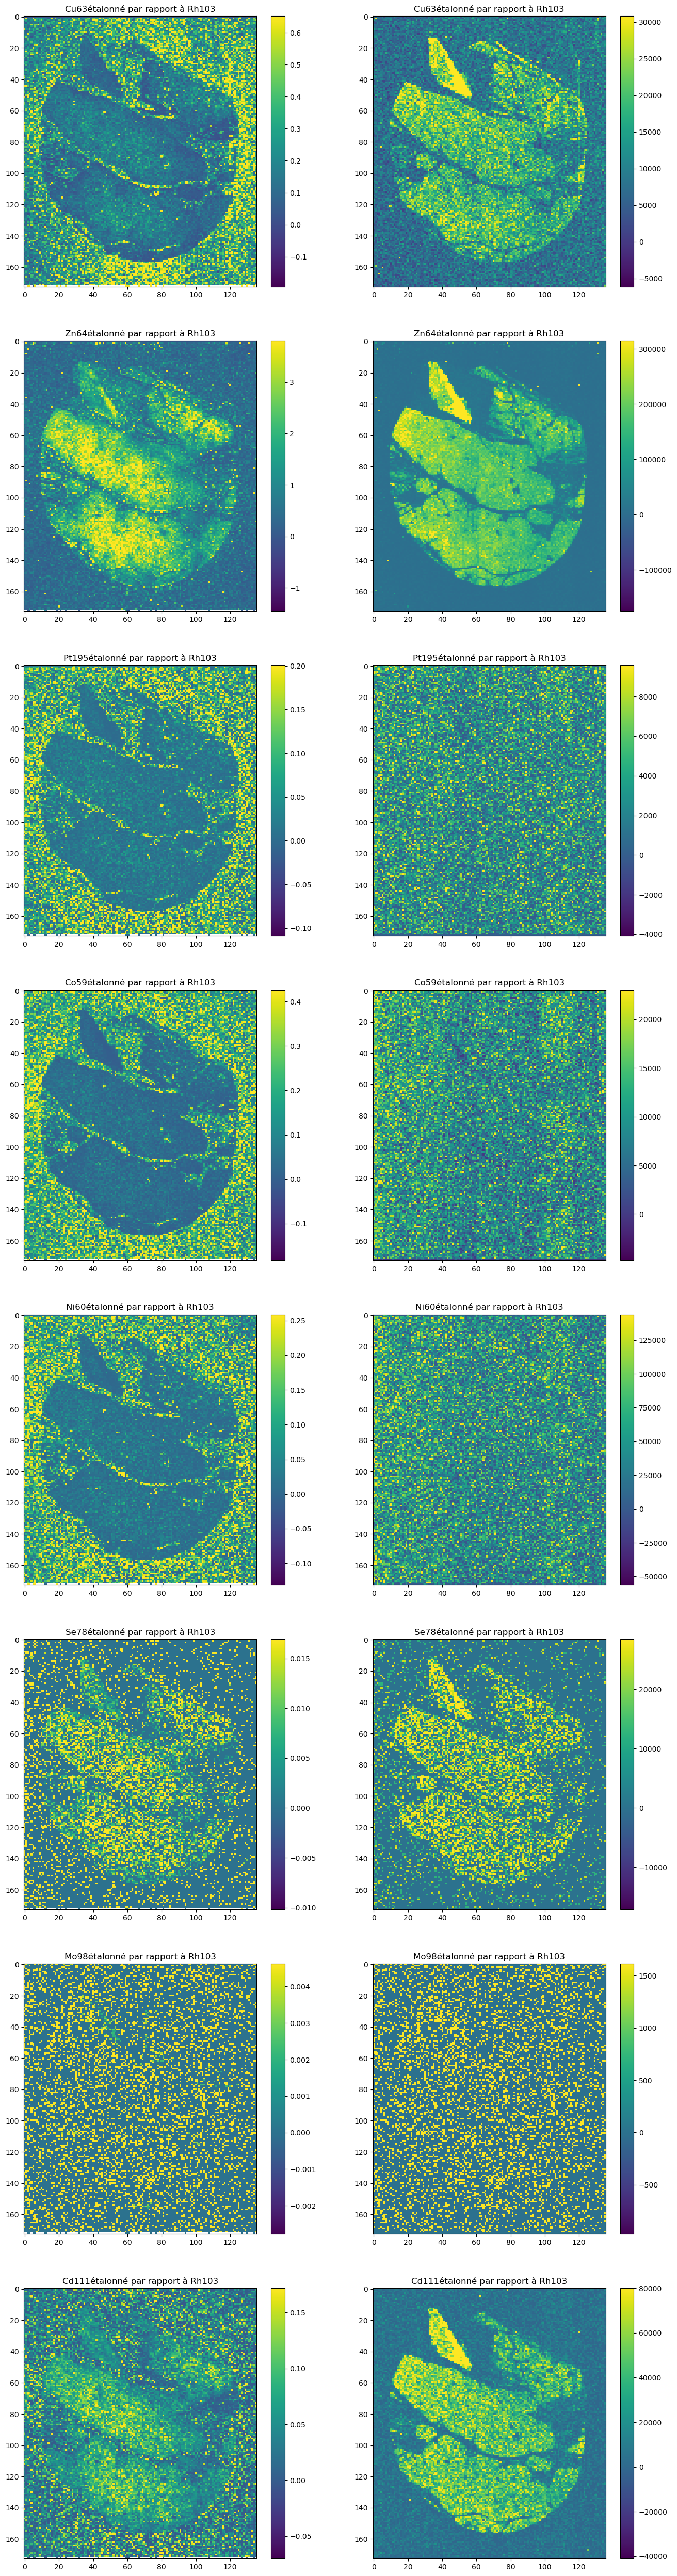

In [428]:
etalon = etalons[1]
plt.figure(figsize=(8*2, 8*2*4))
j = 1
for calibrant in calibrants:
    plt.subplot(8,2,2*j-1)
    draw_image_intensity(136, calibrant, etalon)
    plt.subplot(8,2,2*j)
    draw_image_concentration(136, calibrant, etalon)
    j += 1